### Import Statements

In [218]:
%matplotlib inline

#import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MeanShift, KMeans
from sklearn.metrics.pairwise import cosine_similarity


### Convert CSV file to Dataframe

In [219]:
songs_df = pd.read_csv ('data.csv')
print(songs_df.head())
songs_df = songs_df.drop_duplicates(subset=['id'])
songs_df = songs_df.reset_index(drop=True)

                         artist          title  \
0                      Lil Nas,  Old Town Road   
1  Shawn Mendes, Camila Cabello       Senorita   
2                 Billie Eilish        Bad Guy   
3                        Khalid           Talk   
4     Ed Sheeran, Justin Bieber   I Don't Care   

                                               genre  \
0  Country,Atlanta,Alternative Country,Hip-Hop,Tr...   
1                                                Pop   
2  Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...   
3                                      Synth-Pop,Pop   
4                      Canada,UK,Dance,Dance-Pop,Pop   

                                              lyrics                      id  \
0  Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...  2YpeDb67231RjR0MgVLzsG   
1  Senorita \nI love it when you call me senorita...  0TK2YIli7K1leLovkQiNik   
2  bad guy \nWhite shirt now red, my bloody nose\...  2Fxmhks0bxGSBdJ92vM42m   
3  Talk \nCan we just talk? Can we just ta

### One-hot Encoding for the genres field

In [220]:
def split_genre(song_genre):
    return song_genre.split(',')

In [221]:
songs_df['genre_list']=songs_df['genre'].apply(split_genre)

In [222]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

df = songs_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(songs_df.pop('genre_list')),
                index=songs_df.index,
                columns=mlb.classes_))

In [223]:
df.head().shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6873 entries, 0 to 6872
Columns: 351 entries, artist to \xd0\xa0\xd0\xbe\xd1\x81\xd1\x81\xd0\xb8\xd1\x8f (Russia)
dtypes: Sparse[int32, 0](333), float64(9), int64(4), object(5)
memory usage: 1.1+ MB


### Normalize Spotify Features

In [224]:
### Normalize Tempo column
from sklearn.preprocessing import Normalizer, MinMaxScaler

df['tempo'] = MinMaxScaler().fit_transform(df['tempo'].values.reshape(-1,1))
df['tempo'].head()

0    0.529169
1    0.413461
2    0.523637
3    0.528824
4    0.322617
Name: tempo, dtype: float64

In [225]:
### Isolate audio features into one dataframe
audio_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']
audio_features = df[audio_cols]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B8C0D33148>,
      dtype=object)

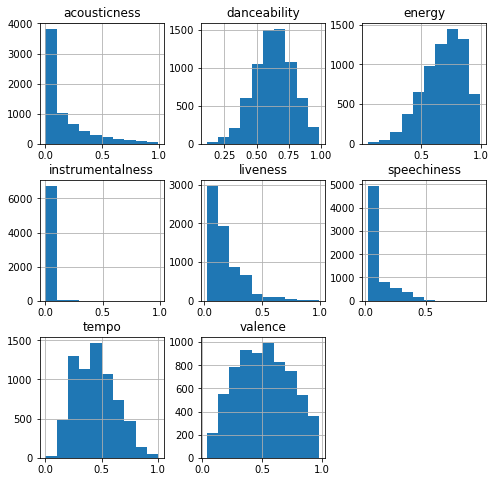

In [226]:
audio_features.hist(figsize=(8,8))


In [227]:
X = df.drop(columns=['id','artist','title','genre','lyrics'])
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,Trip-Hop,Tropical House,UK,UK Rap,Underground Hip-Hop,West Coast,World Music,Worship,YouTube,\xd0\xa0\xd0\xbe\xd1\x81\xd1\x81\xd0\xb8\xd1\x8f (Russia)
0,0.878,0.619,6,-5.560,1,0.1020,0.053300,0.000000,0.1130,0.639,...,0,0,0,0,0,0,0,0,0,0
1,0.759,0.540,9,-6.039,0,0.0287,0.037000,0.000000,0.0945,0.750,...,0,0,0,0,0,0,0,0,0,0
2,0.701,0.425,7,-10.965,1,0.3750,0.328000,0.130000,0.1000,0.562,...,0,0,0,0,0,0,0,0,0,0
3,0.901,0.400,0,-8.575,1,0.1260,0.051000,0.000000,0.0599,0.346,...,0,0,0,0,0,0,0,0,0,0
4,0.798,0.675,6,-5.041,1,0.0442,0.091200,0.000000,0.0894,0.842,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6868,0.652,0.917,6,-6.720,1,0.0548,0.008200,0.000000,0.0509,0.459,...,0,0,0,0,0,0,0,0,0,0
6869,0.516,0.397,5,-10.278,1,0.0274,0.200000,0.000000,0.1200,0.236,...,0,0,0,0,0,0,0,0,0,0
6870,0.470,0.530,8,-10.006,1,0.0317,0.354000,0.000000,0.1900,0.444,...,0,0,0,0,0,0,0,0,0,0
6871,0.535,0.854,1,-6.519,1,0.0368,0.000919,0.001490,0.0676,0.618,...,0,0,0,0,0,0,0,0,0,0


### Elbow Method to find best number of clusters

In [228]:
Ks = np.arange(1, 15)
Ks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

Text(0.5, 1.0, 'Elbow Method')

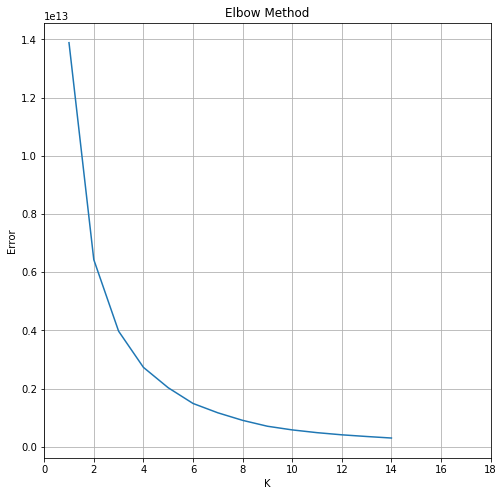

In [14]:
km = [KMeans(n_clusters=i, random_state=1986) for i in Ks]
score = [-km[i].fit(X).score(X) for i in range(len(km))]
Ks.dtype = int
plt.figure(figsize=(8,8))
plt.plot(Ks,score)
plt.xlim(0,18)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Error')
plt.title('Elbow Method')

In [229]:
km = KMeans(n_clusters=6, n_init=10, random_state=1986)
fit_value = km.fit(X)


In [230]:
fit_value = km.predict(X)

In [231]:
len(fit_value)

6873

In [232]:
X['clusters'] = fit_value

In [233]:
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,Tropical House,UK,UK Rap,Underground Hip-Hop,West Coast,World Music,Worship,YouTube,\xd0\xa0\xd0\xbe\xd1\x81\xd1\x81\xd0\xb8\xd1\x8f (Russia),clusters
0,0.878,0.619,6,-5.560,1,0.1020,0.0533,0.00,0.1130,0.639,...,0,0,0,0,0,0,0,0,0,2
1,0.759,0.540,9,-6.039,0,0.0287,0.0370,0.00,0.0945,0.750,...,0,0,0,0,0,0,0,0,0,0
2,0.701,0.425,7,-10.965,1,0.3750,0.3280,0.13,0.1000,0.562,...,0,0,0,0,0,0,0,0,0,0
3,0.901,0.400,0,-8.575,1,0.1260,0.0510,0.00,0.0599,0.346,...,0,0,0,0,0,0,0,0,0,0
4,0.798,0.675,6,-5.041,1,0.0442,0.0912,0.00,0.0894,0.842,...,0,1,0,0,0,0,0,0,0,4


In [234]:
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
print(labels)
print(labels_unique)

[2 0 0 ... 0 2 2]
[0 1 2 3 4 5]


### PCA to reduce dimensions and generate a graph for clusters

In [100]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
x,y = zip(*X_new)
X['x'] = x
X['y'] = y

components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

C:\Users\md\Anaconda\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


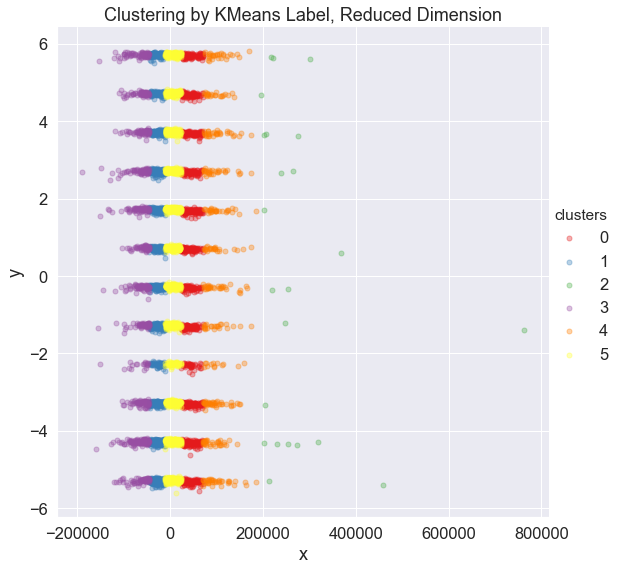

In [101]:
import seaborn as sns

sns.set(font_scale=1.5)

sns.lmplot(data=X, x='x', y='y', hue='clusters', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.title("Clustering by KMeans Label, Reduced Dimension")

plt.savefig('pca_scatter_KM.png')

In [235]:

df['clusters'] = X['clusters']
df.head()

,artist,title,genre,lyrics,id,danceability,energy,key,loudness,mode,...,Tropical House,UK,UK Rap,Underground Hip-Hop,West Coast,World Music,Worship,YouTube,\xd0\xa0\xd0\xbe\xd1\x81\xd1\x81\xd0\xb8\xd1\x8f (Russia),clusters
0,"Lil Nas,",Old Town Road,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",2YpeDb67231RjR0MgVLzsG,0.878,0.619,6,-5.560,1,...,0,0,0,0,0,0,0,0,0,2
1,"Shawn Mendes, Camila Cabello",Senorita,Pop,Senorita \nI love it when you call me senorita...,0TK2YIli7K1leLovkQiNik,0.759,0.540,9,-6.039,0,...,0,0,0,0,0,0,0,0,0,0
2,Billie Eilish,Bad Guy,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","bad guy \nWhite shirt now red, my bloody nose\...",2Fxmhks0bxGSBdJ92vM42m,0.701,0.425,7,-10.965,1,...,0,0,0,0,0,0,0,0,0,0
3,Khalid,Talk,"Synth-Pop,Pop",Talk \nCan we just talk? Can we just talk?\nTa...,6TqXcAFInzjp0bODyvrWEq,0.901,0.400,0,-8.575,1,...,0,0,0,0,0,0,0,0,0,0
4,"Ed Sheeran, Justin Bieber",I Don't Care,"Canada,UK,Dance,Dance-Pop,Pop",I Don't Care \nI'm at a party I don't wanna be...,3HVWdVOQ0ZA45FuZGSfvns,0.798,0.675,6,-5.041,1,...,0,1,0,0,0,0,0,0,0,4


In [236]:
# X['temp'] = 1
# # songs_df = songs_df[['id','artist','title','genre','lyrics']]
# songs_df['temp']=1

In [295]:
songs_df.head()


,artist,title,genre,lyrics,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters
0,"Lil Nas,",Old Town Road,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",2YpeDb67231RjR0MgVLzsG,0.878,0.619,6,-5.560,1,0.1020,0.0533,0.00,0.1130,0.639,136.041,157067,4,2
1,"Shawn Mendes, Camila Cabello",Senorita,Pop,Senorita \nI love it when you call me senorita...,0TK2YIli7K1leLovkQiNik,0.759,0.540,9,-6.039,0,0.0287,0.0370,0.00,0.0945,0.750,116.947,190960,4,0
2,Billie Eilish,Bad Guy,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","bad guy \nWhite shirt now red, my bloody nose\...",2Fxmhks0bxGSBdJ92vM42m,0.701,0.425,7,-10.965,1,0.3750,0.3280,0.13,0.1000,0.562,135.128,194088,4,0
3,Khalid,Talk,"Synth-Pop,Pop",Talk \nCan we just talk? Can we just talk?\nTa...,6TqXcAFInzjp0bODyvrWEq,0.901,0.400,0,-8.575,1,0.1260,0.0510,0.00,0.0599,0.346,135.984,197573,4,0
4,"Ed Sheeran, Justin Bieber",I Don't Care,"Canada,UK,Dance,Dance-Pop,Pop",I Don't Care \nI'm at a party I don't wanna be...,3HVWdVOQ0ZA45FuZGSfvns,0.798,0.675,6,-5.041,1,0.0442,0.0912,0.00,0.0894,0.842,101.956,219947,4,4


In [238]:
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,Tropical House,UK,UK Rap,Underground Hip-Hop,West Coast,World Music,Worship,YouTube,\xd0\xa0\xd0\xbe\xd1\x81\xd1\x81\xd0\xb8\xd1\x8f (Russia),clusters
0,0.878,0.619,6,-5.560,1,0.1020,0.0533,0.00,0.1130,0.639,...,0,0,0,0,0,0,0,0,0,2
1,0.759,0.540,9,-6.039,0,0.0287,0.0370,0.00,0.0945,0.750,...,0,0,0,0,0,0,0,0,0,0
2,0.701,0.425,7,-10.965,1,0.3750,0.3280,0.13,0.1000,0.562,...,0,0,0,0,0,0,0,0,0,0
3,0.901,0.400,0,-8.575,1,0.1260,0.0510,0.00,0.0599,0.346,...,0,0,0,0,0,0,0,0,0,0
4,0.798,0.675,6,-5.041,1,0.0442,0.0912,0.00,0.0894,0.842,...,0,1,0,0,0,0,0,0,0,4


In [239]:
# final_df = pd.merge(songs_df, X, on=['temp'])

In [296]:
songs_df['clusters'] = X['clusters']

In [297]:
songs_df.head()

,artist,title,genre,lyrics,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters
0,"Lil Nas,",Old Town Road,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",2YpeDb67231RjR0MgVLzsG,0.878,0.619,6,-5.560,1,0.1020,0.0533,0.00,0.1130,0.639,136.041,157067,4,2
1,"Shawn Mendes, Camila Cabello",Senorita,Pop,Senorita \nI love it when you call me senorita...,0TK2YIli7K1leLovkQiNik,0.759,0.540,9,-6.039,0,0.0287,0.0370,0.00,0.0945,0.750,116.947,190960,4,0
2,Billie Eilish,Bad Guy,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","bad guy \nWhite shirt now red, my bloody nose\...",2Fxmhks0bxGSBdJ92vM42m,0.701,0.425,7,-10.965,1,0.3750,0.3280,0.13,0.1000,0.562,135.128,194088,4,0
3,Khalid,Talk,"Synth-Pop,Pop",Talk \nCan we just talk? Can we just talk?\nTa...,6TqXcAFInzjp0bODyvrWEq,0.901,0.400,0,-8.575,1,0.1260,0.0510,0.00,0.0599,0.346,135.984,197573,4,0
4,"Ed Sheeran, Justin Bieber",I Don't Care,"Canada,UK,Dance,Dance-Pop,Pop",I Don't Care \nI'm at a party I don't wanna be...,3HVWdVOQ0ZA45FuZGSfvns,0.798,0.675,6,-5.041,1,0.0442,0.0912,0.00,0.0894,0.842,101.956,219947,4,4


In [242]:
# df = df.rename(columns={'\xd0\xa0\xd0\xbe\xd1\x81\xd1\x81\xd0\xb8\xd1\x8f (Russia)': 'Russia'}, inplace=True)


### Group the songs into 6 clusters

In [243]:
 grouped = songs_df.groupby('clusters')


In [244]:
grouped


In [245]:
group1=grouped.get_group(1)
grouped.get_group(1).shape

(1280, 19)

In [246]:
group0 = grouped.get_group(0)
grouped.get_group(0).shape

(2230, 19)

In [247]:
group2 = grouped.get_group(2)
grouped.get_group(2).shape

(783, 19)

In [248]:
group3 =grouped.get_group(3)
grouped.get_group(3).shape

(345, 19)

In [249]:
group4 =grouped.get_group(4)
grouped.get_group(4).shape

(2212, 19)

In [250]:
group5 =grouped.get_group(5)
grouped.get_group(5).shape

(23, 19)

In [299]:
group1.head()
group1 = group1.reset_index(drop=True)
print(group1.head())

                           artist        title  \
0                     Chris Brown  No Guidance   
1                 YG, Tyga, Jon Z      Go Loko   
2  Lunay, Daddy Yankee, Bad Bunny      Soltera   
3                            Sech   Otro Trago   
4                       DJ Khaled     You Stay   

                                               genre  \
0   Alternative R&;B,Hip-Hop,Rap,Pop,DMV,Canada,R&;B   
1                    Trap,Puerto Rico,West Coast,Rap   
2  Reggaeton,Latin Music,Latin Urban,Puerto Rico,...   
3  Dancehall,Reggaeton,Latin Music,Latin Urban,En...   
4     Atlanta,R&;B,Latin Music,En Espa\xc3\xb1ol,Rap   

                                              lyrics                      id  \
0  No Guidance \nBefore I die I'm tryna fuck you,...  6XHVuErjQ4XNm6nDPVCxVX   
1  Go Loko \nMustard on the beat, ho\nMy bitch go...  1kK6DwzyXJSp58u5HYWwuD   
2  Soltera Remix \nepico\nSalte el medio, ¿okay?\...  1c0hsvHLELX6y8qymnpLKL   
3  Otro Trago \nSigue aqui tomandose otro 

### Find Cosine Similarities for each group

In [300]:
#GROUP 1
cosine_similarities = cosine_similarity(group1[audio_cols])


In [301]:
cosine_similarities
print(len(cosine_similarities))

1280


In [302]:
similarities_group1 = {}

for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similarities_group1[group1['id'].iloc[i]] = [[group1['id'][x],cosine_similarities[i][x], group1['title'][x], group1['artist'][x]] for x in similar_indices][1:]
    
print(i)

1279


In [303]:
similarities_group1

{'6XHVuErjQ4XNm6nDPVCxVX': [['4Kw3CztmD15X1QGDnnHmLD',
   0.9999991846235169,
   'Auto Pilot',
   'Migos'],
  ['156LzfvMNKuXuiot4uzhGD',
   0.9999989153605123,
   'No Complaints',
   'Metro Boomin'],
  ['0wbnC9AUenxp613TYaJsGK', 0.9999987578599575, 'Narcos', 'Migos'],
  ['2qcG0nZ6S3zZV0UrkY5nFo', 0.999998662039569, 'Drip', 'Cardi B'],
  ['2jIT1TfSIjVik7Qu1B6P5h',
   0.9999985824991258,
   'Make Love',
   'Gucci Mane, Nicki Minaj']],
 '1kK6DwzyXJSp58u5HYWwuD': [['2xxx3hyrkpFgrGi6iCVx9y',
   0.9999982497930936,
   'Hope',
   'Twista'],
  ['3ndumr5hw721OmT5opZ5Zl', 0.9999978406832283, 'Errrbody', 'Yo Gotti'],
  ['490r1lg2turCiWsPAAxVBP', 0.9999974032765838, 'Bed Of Lies', 'Nicki Minaj'],
  ['0oVWPlnK5eAqnJCVB0FvpP',
   0.9999969000683515,
   'American Soldier',
   'Toby Keith'],
  ['6gU9OKjOE7ghfEd55oRO57', 0.9999965892645645, 'The Weekend', 'SZA']],
 '1c0hsvHLELX6y8qymnpLKL': [['0Uyh92tLyb9JawG8lmWCzJ',
   0.9999968539259088,
   'Differences',
   'Ginuwine'],
  ['5ZKVNTG7yu7gbX4vryqS2X',

In [304]:
len(similarities_group1)

1280

In [305]:
#group 2
group2 = group2.reset_index(drop=True)
print(group2.head())
cosine_similarities = cosine_similarity(group2[audio_cols])
len(cosine_similarities)

           artist          title  \
0        Lil Nas,  Old Town Road   
1  Jonas Brothers         Sucker   
2          DaBaby           Suge   
3     Post Malone           Wow.   
4           Lizzo    Truth Hurts   

                                               genre  \
0  Country,Atlanta,Alternative Country,Hip-Hop,Tr...   
1     Alternative Pop,Boy Band,Teen Pop,Pop-Rock,Pop   
2                                Trap,East Coast,Rap   
3                             Memes,Hip-Hop,Trap,Rap   
4                                            Pop,Rap   

                                              lyrics                      id  \
0  Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...  2YpeDb67231RjR0MgVLzsG   
1  Sucker \nWe go together\nBetter than birds of ...  22vgEDb5hykfaTwLuskFGD   
2  Suge \nPooh, you a fool for this one\nHa\nOh L...  2gwkD6igEhQbDQegRCcdoB   
3  Wow \nSaid she tired of little money, need a b...  7xQAfvXzm3AkraOtGPWIZg   
4  Truth Hurts \nWhy're men great til they got

783

In [306]:
similaritites_group2 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group2[group2['id'].iloc[i]] = [[group2['id'][x],cosine_similarities[i][x], group2['title'][x], group2['artist'][x]] for x in similar_indices][1:]

In [307]:
len(similaritites_group2)

783

In [309]:
group3 = group3.reset_index(drop=True)
print(group3.head())
#GROUP3
cosine_similarities = cosine_similarity(group3[audio_cols])
len(cosine_similarities)
similaritites_group3 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group3[group3['id'].iloc[i]] = [[group3['id'][x],cosine_similarities[i][x], group3['title'][x], group3['artist'][x]] for x in similar_indices][1:]
len(similaritites_group3)

          artist                  title  \
0   Travis Scott             Sicko Mode   
1  Nipsey Hussle              Double Up   
2      Lady Gaga  I'll Never Love Again   
3      Meek Mill            What's Free   
4          Queen      Bohemian Rhapsody   

                                               genre  \
0                      Hip-Hop,Memes,Rap,Canada,Trap   
1                                     West Coast,Rap   
2                            Musicals,Soundtrack,Pop   
3                                     East Coast,Rap   
4  Memes,Piano,British Rock,Adult Alternative,Bar...   

                                              lyrics                      id  \
0  SICKO MODE \nAstro, yeah\nSun is down, freezin...  2xLMifQCjDGFmkHkpNLD9h   
1  Double Up \nDouble up\nThree or four times, I ...  4iVD0fTHGxV9JWloujsL3s   
2  I'll Never Love Again Extended Version \nWish ...  2fbJ5Msx8KoDKpyufH5YsU   
3  What's Free \nYou know what free is, nigga?\nW...  4iQ5gmTAzWfK8JyFC2LBox   
4  B

345

In [310]:
group4 = group4.reset_index(drop=True)
print(group4.head())
#GROUP3
cosine_similarities = cosine_similarity(group4[audio_cols])
len(cosine_similarities)
similaritites_group4 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group4[group4['id'].iloc[i]] = [[group4['id'][x],cosine_similarities[i][x], group4['title'][x], group4['artist'][x]] for x in similar_indices][1:]
len(similaritites_group4)

                      artist              title  \
0  Ed Sheeran, Justin Bieber       I Don't Care   
1                 Katy Perry  Never Really Over   
2              Morgan Wallen    Whiskey Glasses   
3                     Khalid             Better   
4                     Halsey          Nightmare   

                                               genre  \
0                      Canada,UK,Dance,Dance-Pop,Pop   
1                          Electro-Pop,Synth-Pop,Pop   
2                                            Country   
3                               Electro-Pop,Pop,R&;B   
4  Alternative Rock,Alternative Pop,Alternative,P...   

                                              lyrics                      id  \
0  I Don't Care \nI'm at a party I don't wanna be...  3HVWdVOQ0ZA45FuZGSfvns   
1  Never Really Over \nI'm losing my self control...  5PYQUBXc7NYeI1obMKSJK0   
2  Whiskey Glasses \nPoor me, pour me another dri...  6foY66mWZN0pSRjZ408c00   
3  Better \nBetter\nNothing, baby\nN

2212

In [311]:
group5 = group5.reset_index(drop=True)
print(group5.head())
#GROUP5
cosine_similarities = cosine_similarity(group5[audio_cols])
len(cosine_similarities)
similaritites_group5 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group5[group5['id'].iloc[i]] = [[group5['id'][x],cosine_similarities[i][x], group5['title'][x], group5['artist'][x]] for x in similar_indices][1:]
len(similaritites_group5)

                                  artist                 title  \
0                         Kendrick Lamar                 Fear.   
1                                J. Cole      4 Your Eyez Only   
2                            David Bowie             Blackstar   
3  The White Buffalo, The Forest Rangers  Come Join The Murder   
4                      Justin Timberlake       Not A Bad Thing   

                                               genre  \
0  Gospel,Pop,Producer,Conscious Hip-Hop,Christia...   
1                                       Boom Bap,Rap   
2  Experimental,British Rock,UK,Avant Garde,Drum ...   
3                                     Rock,Folk Rock   
4                                           R&;B,Pop   

                                              lyrics                      id  \
0  FEAR \nPoverty's paradise\nI don't think I cou...  23luOrEVHMfoX0AhfbQuS6   
1  4 Your Eyez Only \nYeah For your eyes\nFor you...  1vvnYpYEMVB4aq9I6tHIEB   
2  Blackstar ★ \nIn the vi

23

In [312]:
group0 = group0.reset_index(drop=True)
print(group0.head())
#GROUP0
cosine_similarities = cosine_similarity(group0[audio_cols])
len(cosine_similarities)
similaritites_group0 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group0[group0['id'].iloc[i]] = [[group0['id'][x],cosine_similarities[i][x], group0['title'][x], group0['artist'][x]] for x in similar_indices][1:]
len(similaritites_group0)

                         artist                title  \
0  Shawn Mendes, Camila Cabello             Senorita   
1                 Billie Eilish              Bad Guy   
2                        Khalid                 Talk   
3                         Drake   Money In The Grave   
4                  Shawn Mendes  If I Can't Have You   

                                               genre  \
0                                                Pop   
1  Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...   
2                                      Synth-Pop,Pop   
3                  Hip-Hop,Rap,Basketball,NBA,Canada   
4                                Canada,Teen Pop,Pop   

                                              lyrics                      id  \
0  Senorita \nI love it when you call me senorita...  0TK2YIli7K1leLovkQiNik   
1  bad guy \nWhite shirt now red, my bloody nose\...  2Fxmhks0bxGSBdJ92vM42m   
2  Talk \nCan we just talk? Can we just talk?\nTa...  6TqXcAFInzjp0bODyvrWEq   
3  Mon

2230

## Extra code for UI

In [38]:
similarities_evaluation = {}

for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-50:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similarities_evaluation[songs_df['id'].iloc[i]] = [[songs_df['id'][x],cosine_similarities[i][x], songs_df['title'][x], songs_df['artist'][x]] for x in similar_indices][1:6]

In [51]:

#cosine similariy for whole dataset
audio_cols.append('clusters')
cosine_similarities_songs_df = cosine_similarity(songs_df[audio_cols])


In [52]:
similarities_songs_df = {}

for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-6:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similarities_songs_df[songs_df['id'].iloc[i]] = [[songs_df['id'][x],cosine_similarities[i][x], songs_df['title'][x], songs_df['artist'][x]] for x in similar_indices][1:6]

In [53]:
similarities_songs_df


{'2YpeDb67231RjR0MgVLzsG': [['4NiehSBQthimPzRsVeOgCT',
   0.9999997905620683,
   'My My My!',
   'Troye Sivan'],
  ['3OUApyz3jDB3syGUNGqB1d',
   0.9999997584095995,
   'How You Gonna Act Like That',
   'Tyrese'],
  ['6xNnPtnmqpktZLFkgT21u7',
   0.9999997533596212,
   'Give It To You',
   'Jordan Knight'],
  ['5uqphUYsR45kPYplrYSAQh',
   0.9999997468609725,
   'Throw Sum Mo',
   'Rae Sremmurd']],
 '0TK2YIli7K1leLovkQiNik': [['0KKkJNfGyhkQ5aFogxQAPU',
   0.9999998637684289,
   "That's What I Like",
   'Bruno Mars'],
  ['4MKzCHlZvkwJOQRNkdw4zq', 0.9999998210724881, 'Sexy Chick', 'David Guetta'],
  ['2ZDxfuXmTIRCdXChbtHpW9',
   0.9999998104913449,
   'Give You What You Want',
   'Chico DeBarge'],
  ['16QN8cBubEq706vNtPpOME',
   0.9999996856375096,
   'Love So Soft',
   'Kelly Clarkson']],
 '2Fxmhks0bxGSBdJ92vM42m': [['55393H9JXqdX1gTo0N3G7H',
   0.9999984435515383,
   'Put On',
   'Young Jeezy'],
  ['1AcKboMkn1HekyJSlKKEc3',
   0.9999983838381774,
   'Diamond In The Back',
   'Ludacris'],


In [338]:
#FOR UI
#GROUP1
cosine_similarities = cosine_similarity(group0[audio_cols])
len(cosine_similarities)
similaritites_group0 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group0[group0['artist'].iloc[i]+" \t "+group0['title'].iloc[i]] = [[group0['artist'][x]+" \t "+group0['title'][x]] for x in similar_indices][1:]
len(similaritites_group0)

2230

In [339]:
#FOR UI
#GROUP1
cosine_similarities = cosine_similarity(group1[audio_cols])
len(cosine_similarities)
similaritites_group1 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group1[group1['artist'].iloc[i]+" \t "+group1['title'].iloc[i]] = [[group1['artist'][x]+" \t "+group1['title'][x]] for x in similar_indices][1:]
len(similaritites_group1)

1280

In [340]:
#FOR UI
#GROUP2
cosine_similarities = cosine_similarity(group2[audio_cols])
len(cosine_similarities)
similaritites_group2 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group2[group2['artist'].iloc[i]+" \t "+group2['title'].iloc[i]] = [[group2['artist'][x]+" \t "+group2['title'][x]] for x in similar_indices][1:]
len(similaritites_group2)

783

In [341]:
cosine_similarities = cosine_similarity(group3[audio_cols])
len(cosine_similarities)
similaritites_group3 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group3[group3['artist'].iloc[i]+" \t "+group3['title'].iloc[i]] = [[group3['artist'][x]+" \t "+group3['title'][x]] for x in similar_indices][1:]
len(similaritites_group3)

345

In [342]:
cosine_similarities = cosine_similarity(group4[audio_cols])
len(cosine_similarities)
similaritites_group4 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group4[group4['artist'].iloc[i]+" \t "+group4['title'].iloc[i]] = [[group4['artist'][x]+" \t "+group4['title'][x]] for x in similar_indices][1:]
len(similaritites_group4)

2212

In [343]:
cosine_similarities = cosine_similarity(group5[audio_cols])
len(cosine_similarities)
similaritites_group5 = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-7:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similaritites_group5[group5['artist'].iloc[i]+" \t "+group5['title'].iloc[i]] = [[group5['artist'][x]+" \t "+group5['title'][x]] for x in similar_indices][1:]
len(similaritites_group5)

23

In [344]:
similaritites_group0

{'Shawn Mendes, Camila Cabello \t Senorita': [["Bruno Mars \t That's What I Like"],
  ['David Guetta \t Sexy Chick'],
  ['Jay Sean \t Do You Remember'],
  ['R. Kelly \t Ignition'],
  ['Sean Kingston, Justin Bieber \t Eenie Meenie']],
 'Billie Eilish \t Bad Guy': [["Drake \t I'm Upset"],
  ['J. Cole \t Neighbors'],
  ['ScHoolboy Q \t Floating'],
  ['Cardi B \t I Do'],
  ['Sage The Gemini \t Red Nose']],
 'Khalid \t Talk': [['Gucci Mane \t Both'],
  ['Young Thug \t Chanel'],
  ['Young Thug \t With Them'],
  ['Lil Wayne \t What About Me'],
  ['Wiz Khalifa \t Fr Fr']],
 'Drake \t Money In The Grave': [['T.I. \t No Mediocre'],
  ['Bad Bunny \t MIA'],
  ['Childish Gambino \t Summertime Magic'],
  ['Nick Jonas, Nicki Minaj \t Bom Bidi Bom'],
  ['Lorde \t Homemade Dynamite']],
 "Shawn Mendes \t If I Can't Have You": [['Sara Bareilles \t King Of Anything'],
  ['Rihanna \t You Da One'],
  ['Pearl Jam \t Last Kiss'],
  ['A Boogie Wit da Hoodie \t Drowning'],
  ['Enrique Iglesias \t Loco']],
 'Hal

In [347]:
import json

with open('model2_UI_data.json', 'w') as fp:
    json.dump(similaritites_group0, fp)
    json.dump(similaritites_group2, fp)
    json.dump(similaritites_group3, fp)
    json.dump(similaritites_group4, fp)
    json.dump(similaritites_group5, fp)
    json.dump(similaritites_group1, fp)


In [345]:
similaritites_group5


{'Kendrick Lamar \t Fear.': [['Justin Timberlake \t Pusher Love Girl'],
  ['R. Kelly \t Trapped In The Closet'],
  ['The White Buffalo, The Forest Rangers \t Come Join The Murder'],
  ['David Bowie \t Blackstar'],
  ['Death Cab For Cutie \t I Will Possess Your Heart']],
 'J. Cole \t 4 Your Eyez Only': [['Justin Timberlake \t Mirrors'],
  ['R. Kelly \t Step In The Name Of Love'],
  ['R. Kelly \t Happy People'],
  ['Marsha Ambrosius \t Far Away'],
  ['R. Kelly \t Trapped In The Closet']],
 'David Bowie \t Blackstar': [['deadmau5 \t Raise Your Weapon'],
  ['The Roots \t Break You Off'],
  ['Avenged Sevenfold \t Not Ready To Die'],
  ['Green Day \t Holiday'],
  ['Dirty Vegas \t Days Go By']],
 'The White Buffalo, The Forest Rangers \t Come Join The Murder': [['Justin Timberlake \t Not A Bad Thing'],
  ['Kendrick Lamar \t Fear.'],
  ['David Bowie \t Blackstar'],
  ['Justin Timberlake \t Pusher Love Girl'],
  ['R. Kelly \t Trapped In The Closet']],
 'Justin Timberlake \t Not A Bad Thing': [[

In [346]:
similaritites_group4

{"Ed Sheeran, Justin Bieber \t I Don't Care": [['Sugar Ray \t Every Morning'],
  ['Before Dark \t Monica'],
  ["Mariah Carey \t Say Somethin'"],
  ['Sean Paul \t Gimme The Light'],
  ['will.i.am \t I Got It From My Mama']],
 'Katy Perry \t Never Really Over': [['Craig Morgan \t International Harvester'],
  ['The Weeknd \t Party Monster'],
  ['Beyonce \t Before I Let Go'],
  ['Coko \t Sunshine'],
  ['The Chainsmokers \t Roses']],
 'Morgan Wallen \t Whiskey Glasses': [['LANCO \t Greatest Love Story'],
  ['Taylor Swift \t Mean'],
  ['R. City \t Locked Away'],
  ['Juice WRLD \t Robbery'],
  ['Ne \t Miss Independent']],
 'Khalid \t Better': [['The White Stripes \t Seven Nation Army'],
  ['The Killers \t Shadowplay'],
  ['twenty one pilots \t Jumpsuit'],
  ['David Guetta \t Titanium'],
  ['Skrillex \t Scary Monsters And Nice Sprites']],
 'Halsey \t Nightmare': [['T.I. \t Whatever You Like'],
  ["Kumbia Kings \t U Don't Love Me"],
  ['Katy Perry \t Wide Awake'],
  ['Rihanna \t SOS'],
  ['Nata

In [349]:
similaritites_group3

{'Travis Scott \t Sicko Mode': [["Lil Jon, The East Side Boyz \t What U Gon' Do"],
  ['will.i.am \t Fall Down'],
  ['Nipsey Hussle \t Double Up'],
  ['Lil Wayne \t Blunt Blowin'],
  ['Rae Sremmurd, Juicy J \t Powerglide']],
 'Nipsey Hussle \t Double Up': [['Travis Scott \t Sicko Mode'],
  ['Beyonce \t Mine'],
  ['The Carters \t Friends'],
  ['Migos, Nicki Minaj, Cardi B \t MotorSport'],
  ["Lil Jon, The East Side Boyz \t What U Gon' Do"]],
 "Lady Gaga \t I'll Never Love Again": [['Taylor Swift \t Last Kiss'],
  ['Bilal \t Soul Sista'],
  ["Martina McBride \t God's Will"],
  ['Frank Ocean \t Nikes'],
  ['Mint Condition \t If You Love Me']],
 "Meek Mill \t What's Free": [["T.I. \t That's All She Wrote"],
  ['Drake \t Emotionless'],
  ['T.I. \t No Matter What'],
  ['Eminem \t Stepping Stone'],
  ['The Game \t My Life']],
 'Queen \t Bohemian Rhapsody': [['Marvin Sapp \t Never Would Have Made It'],
  ['Drake \t Since Way Back'],
  ['Glee Cast \t Bohemian Rhapsody'],
  ['Bon Jovi \t Thank Yo

In [350]:
similaritites_group2

{'Lil Nas, \t Old Town Road': [['Bazzi \t Paradise'],
  ['XXXTENTACION \t Going Down!'],
  ['Cardi B \t Ring'],
  ['Dae Dae \t Wat U Mean'],
  ['Lil Pump \t Esskeetit']],
 'Jonas Brothers \t Sucker': [['Daniel Bedingfield \t Gotta Get Thru This'],
  ['Meghan Trainor \t Lips Are Movin'],
  ['Ashlee Simpson \t Boyfriend'],
  ['The Offspring \t Hit That'],
  ['Thomas Rhett \t Unforgettable']],
 'DaBaby \t Suge': [['Future, Juice WRLD \t Astronauts'],
  ['Plies \t Rock'],
  ['6ix9ine \t Billy'],
  ['Buck 22 \t Achy Breaky 2'],
  ['Azul Azul \t La Bomba']],
 'Post Malone \t Wow.': [['Offset, Metro Boomin \t Ric Flair Drip'],
  ['Bhad Bhabie \t These Heaux'],
  ['DJ Khaled \t For Free'],
  ['Drake \t 6 God'],
  ['Blueface \t Thotiana']],
 'Lizzo \t Truth Hurts': [['City Girls \t Twerk'],
  ['Juice WRLD \t Maze'],
  ['6ix9ine \t Gotti'],
  ['Playboi Carti \t Shoota'],
  ['Lil Nas X \t Panini']],
 'Post Malone, Swae Lee \t Sunflower': [['Frank Sinatra \t Jingle Bells'],
  ['Glee Cast \t One Lo

In [ ]:
import json

with open('model2_evaluation.json', 'w') as fp:
    json.dump(similaritites_group0, fp)
    json.dump(similaritites_group2, fp)
    json.dump(similaritites_group3, fp)
    json.dump(similaritites_group4, fp)
    json.dump(similaritites_group5, fp)
    json.dump(similarities_group1, fp)